# Notebook for ANNDL - Homework 2

Team: All Is Well

Team members: Fatma Hamila, Kodai Takigawa, Zheng Maria Yu

In [ ]:
!unzip /dataset.zip 

# Setup
Firstly, we need to setup the environment by importing the required libraries, setting the current path (eventually mounting Google Drive), and fixing the random seed for our experiments' reproducibility.

The dataset should be present in the same folder of this notebook.

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
use_drive = False

In [3]:
# Connect to Google Drive
# Set path

if(use_drive):
    from google.colab import drive
    drive.mount('/gdrive')
    path = "/gdrive/My Drive/ANNDL/2022-23/Homework2"
    %cd /gdrive/My Drive/ANNDL/2022-23/Homework2
else:
    path = os.getcwd()
    print(str(path))

C:\Users\zheng\Documents\Uni\Magistrale\ANNDL\22-23\Homework2\Env


In [4]:
# Fix random seed for reproducibility
seed = 23

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Set dataset directory
dataset_dir = 'dataset'

In [6]:
# Load data
X_all_raw = np.load(os.path.join(dataset_dir, 'x_train.npy'))
y_all_raw = np.load(os.path.join(dataset_dir, 'y_train.npy'))

In [7]:
print(X_all_raw.shape,y_all_raw.shape)

(2429, 36, 6) (2429,)


In [8]:
max(y_all_raw),min(y_all_raw)

(11, 0)

# Data Preprocessing & Splitting
In this part, the extracted data is preprocessed and splitted into a training set and a validation set.

In [12]:
# Combine data sequences belonging to the same class
def combine_frame(x,y):
    new_data=[]
    for i in range(12):
        index=np.where(y==i)[0]
        data=x[index[0]]
        for j in index[1:]:
            data=np.concatenate((data,x[j]),axis=0)
        new_data.append(data)
    return new_data

data=combine_frame(X_all_raw,y_all_raw)
for a in data:
    print(a.shape)

(1224, 6)
(4428, 6)
(9720, 6)
(13716, 6)
(2232, 6)
(5508, 6)
(11268, 6)
(2448, 6)
(4320, 6)
(27972, 6)
(2772, 6)
(1836, 6)


In [13]:
# Split training sequence and validation sequence
X_train,X_val=[d[:int(len(d)*0.8)] for d in data],[d[int(len(d)*0.8):] for d in data]

In [15]:
# Split the long sequences into shorter ones with the sliding window
def split_data(x,y,window=24,step=1):
    data=[]
    target=[]
    
    for i in range(len(x)):
        a=x[i]
        b=y[i]
        for j in range(0,len(a)-window,step):
            data.append(a[j:j+window])
            target.append(b)
            
    return np.asarray(data),np.asarray(target)

In [16]:
X_train,y_train=split_data(X_train,range(12),window=36,step=6)
X_train.shape,y_train.shape

((11592, 36, 6), (11592,))

In [17]:
X_val,y_val=split_data(X_val,range(12),window=36,step=36)
X_val.shape,y_val.shape

((479, 36, 6), (479,))

In [18]:
# Normalize the data
def normalize_data(x):
    new_x=[]
    
    for i in range(len(x)):
        a=x[i]
        max_,min_,mean_,std_=a.max(axis=0),a.min(axis=0),a.mean(axis=0),a.std(axis=0)
        b=np.concatenate((max_,min_,mean_,std_)).reshape((-1,6))
        a=2*(a-min_)/(max_-min_)-1
        a=np.concatenate((a,b))
        new_x.append(a)
        
    return np.array(new_x)

X_train = normalize_data(X_train)
X_val = normalize_data(X_val)

In [19]:
# Convert the integer labels to one-hot encoding
y_train = tfk.utils.to_categorical(y_train.reshape((-1,1)))
y_val = tfk.utils.to_categorical(y_val.reshape((-1,1)))

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11592, 40, 6), (11592, 12), (479, 40, 6), (479, 12))

# Model training

In [21]:
# Set the values for training
input_shape = (36, 6)
classes = 12
batch_size = 128
epochs = 100

In [22]:
input_shape, classes

((36, 6), 12)

In [26]:
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, concatenate, Activation, GRU, SimpleRNN,MaxPool1D,Bidirectional,GlobalMaxPooling1D,Concatenate
from attention import Attention

def build_model(input_shape, classes):

    input = tfkl.Input(shape=input_shape, name='Input')
    x_input=input

    # 512
    x1 = Bidirectional(LSTM(units=256, return_sequences=True))(x_input)
        
    # 384
    l1 = Bidirectional(LSTM(units=192, return_sequences=True))(x1)
    l2 = Bidirectional(LSTM(units=192, return_sequences=True))(x_input)

    c1 = Concatenate(axis=2)((l1,l2))
    
    # 256
    l3 = Bidirectional(LSTM(units=128, return_sequences=True))(c1)
    l4 = Bidirectional(LSTM(units=128, return_sequences=True))(l2)

    c2 = Concatenate(axis=2)((l3,l4))
    
    l6 = GlobalMaxPooling1D()(c2)
    
#    a1 = Attention()(c2)
    
    l7 = Dense(units=128, activation='relu')(l6)
    l8 = Dropout(0.3, seed=seed)(l7)
        
    output = Dense(12, activation='softmax')(l8)

    model = tfk.Model(inputs=input, outputs=output)
    
    # Compile the model
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    # Return the model
    return model

In [27]:
# Build the model
model = build_model((36,6), classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 36, 512)     538624      ['Input[0][0]']                  
 )                                                                                                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 36, 384)     1082880     ['bidirectional_5[0][0]']        
 )                                                                                                
                                                                                            

# Checkpoint and Early stopping settings
Early stopping options can be activated to limit model overfitting.

There is possibility to save checkpoints during the training, in order to keep track of the performance and to get more choices of the final model.


In [28]:
os.getcwd()

'C:\\Users\\zheng\\Documents\\Uni\\Magistrale\\ANNDL\\22-23\\Homework2\\Env'

In [29]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')
    print(now)

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    ckpt_dir = os.path.join(exp_dir, 'base_ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,# True to save only the best epoch
                                                     monitor='val_accuracy')
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)
    

    return callbacks, now

In [30]:
foldermode = "ResLSTM"

In [31]:
# Define the callbacks
callbacks, date = create_folders_and_callbacks(foldermode)

Dec17_22-33-03


In [32]:
foldername = foldermode + '_' + str(date)
print(foldername)

ResLSTM_Dec17_22-33-03


In [33]:
# Define the generator for augmented samples
from tensorflow.keras.utils import Sequence
import augmentationrepo.utils.augmentation as aug

class AugmentDataGenerator(Sequence):

    def __init__(self, data,target,p=0.1,batch_size=64):
        self.data = data
        self.target=target
        self.p=p
        self.augment=[aug.jitter,aug.scaling,aug.permutation,
                      aug.magnitude_warp,aug.time_warp,
                      aug.rotation,aug.window_slice,aug.window_warp]

        self.batch_size=batch_size
        self.perm=np.random.permutation(len(self.data))
        
    def __len__(self):
          if len(self.data)%self.batch_size==0:
            return len(self.data)//self.batch_size
          return len(self.data)//self.batch_size+1

    def getitem(self,x):
        data,target=self.data[x],self.target[x]
        max_,min_=data[36],data[37]
        data=data[:36]
        for f in self.augment:
            if np.random.rand()<self.p:
                data = f(np.array([data]))[0]
                
        data=(data+1)*(max_-min_)/2+min_
        return (np.array(data), np.array(target))
    
    def __getitem__(self, x):
        data,target=[],[]
        for i in self.perm[x*self.batch_size:min(len(self.data),(x+1)*self.batch_size)]:
              a,b=self.getitem(i)
              data.append(a)
              target.append(b)
        if ((x+1)*self.batch_size)>len(self.data):
            self.perm=np.random.permutation(len(self.data))
        return (np.array(data), np.array(target))
        


generator=AugmentDataGenerator(X_train,y_train,p=0.5)
data,target=generator.__getitem__(0)
print(data.shape,target.shape)

(64, 36, 6) (64, 12)


In [34]:
val_generator=AugmentDataGenerator(X_val,y_val,p=0)
data,target=generator.__getitem__(0)
print(data.shape,target.shape)

(64, 36, 6) (64, 12)


In [35]:
history = model.fit(
    generator,
    validation_data = val_generator,
    epochs = 500,
    shuffle=False,
    callbacks=callbacks
).history

Epoch 1/500
182/182 [==============================] - ETA: 0s - loss: 1.8316 - accuracy: 0.4066

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_01.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_01.ckpt\assets


182/182 [==============================] - 141s 674ms/step - loss: 1.8316 - accuracy: 0.4066 - val_loss: 1.4601 - val_accuracy: 0.4969
Epoch 2/500
181/182 [============================>.] - ETA: 0s - loss: 1.5417 - accuracy: 0.4831

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_02.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_02.ckpt\assets


182/182 [==============================] - 114s 632ms/step - loss: 1.5414 - accuracy: 0.4831 - val_loss: 1.2504 - val_accuracy: 0.5762
Epoch 3/500
181/182 [============================>.] - ETA: 0s - loss: 1.4440 - accuracy: 0.5084

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_03.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_03.ckpt\assets


182/182 [==============================] - 115s 633ms/step - loss: 1.4440 - accuracy: 0.5085 - val_loss: 1.1433 - val_accuracy: 0.6138
Epoch 4/500
181/182 [============================>.] - ETA: 0s - loss: 1.3785 - accuracy: 0.5275

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_04.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_04.ckpt\assets


182/182 [==============================] - 114s 629ms/step - loss: 1.3784 - accuracy: 0.5274 - val_loss: 1.0845 - val_accuracy: 0.6326
Epoch 5/500
181/182 [============================>.] - ETA: 0s - loss: 1.3578 - accuracy: 0.5377

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_05.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_05.ckpt\assets


182/182 [==============================] - 113s 623ms/step - loss: 1.3580 - accuracy: 0.5378 - val_loss: 1.0562 - val_accuracy: 0.6472
Epoch 6/500
182/182 [==============================] - 38s 210ms/step - loss: 1.3153 - accuracy: 0.5531 - val_loss: 1.0200 - val_accuracy: 0.6430
Epoch 7/500
182/182 [==============================] - 38s 210ms/step - loss: 1.2830 - accuracy: 0.5622 - val_loss: 1.0134 - val_accuracy: 0.6388
Epoch 8/500
181/182 [============================>.] - ETA: 0s - loss: 1.2723 - accuracy: 0.5653

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_08.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_08.ckpt\assets


182/182 [==============================] - 117s 648ms/step - loss: 1.2726 - accuracy: 0.5653 - val_loss: 0.9984 - val_accuracy: 0.6534
Epoch 9/500
181/182 [============================>.] - ETA: 0s - loss: 1.2423 - accuracy: 0.5792

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_09.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_09.ckpt\assets


182/182 [==============================] - 111s 615ms/step - loss: 1.2424 - accuracy: 0.5792 - val_loss: 0.9884 - val_accuracy: 0.6555
Epoch 10/500
182/182 [==============================] - 14s 74ms/step - loss: 1.2478 - accuracy: 0.5720 - val_loss: 0.9842 - val_accuracy: 0.6534
Epoch 11/500
181/182 [============================>.] - ETA: 0s - loss: 1.2186 - accuracy: 0.5751

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_11.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_11.ckpt\assets


182/182 [==============================] - 86s 473ms/step - loss: 1.2186 - accuracy: 0.5751 - val_loss: 0.9678 - val_accuracy: 0.6576
Epoch 12/500
182/182 [==============================] - 14s 74ms/step - loss: 1.2136 - accuracy: 0.5832 - val_loss: 0.9676 - val_accuracy: 0.6493
Epoch 13/500
182/182 [==============================] - 13s 73ms/step - loss: 1.1921 - accuracy: 0.5893 - val_loss: 0.9634 - val_accuracy: 0.6576
Epoch 14/500
182/182 [==============================] - 13s 74ms/step - loss: 1.1873 - accuracy: 0.5953 - val_loss: 0.9421 - val_accuracy: 0.6514
Epoch 15/500
182/182 [==============================] - 13s 73ms/step - loss: 1.1793 - accuracy: 0.5910 - val_loss: 0.9819 - val_accuracy: 0.6409
Epoch 16/500
181/182 [============================>.] - ETA: 0s - loss: 1.1729 - accuracy: 0.5960

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_16.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_16.ckpt\assets


182/182 [==============================] - 88s 484ms/step - loss: 1.1730 - accuracy: 0.5959 - val_loss: 0.9452 - val_accuracy: 0.6597
Epoch 17/500
181/182 [============================>.] - ETA: 0s - loss: 1.1469 - accuracy: 0.6037

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_17.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_17.ckpt\assets


182/182 [==============================] - 84s 463ms/step - loss: 1.1470 - accuracy: 0.6036 - val_loss: 0.9230 - val_accuracy: 0.6618
Epoch 18/500
182/182 [==============================] - 13s 73ms/step - loss: 1.1504 - accuracy: 0.6052 - val_loss: 0.9237 - val_accuracy: 0.6555
Epoch 19/500
181/182 [============================>.] - ETA: 0s - loss: 1.1354 - accuracy: 0.6091

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_19.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_19.ckpt\assets


182/182 [==============================] - 85s 466ms/step - loss: 1.1352 - accuracy: 0.6091 - val_loss: 0.9090 - val_accuracy: 0.6722
Epoch 20/500
182/182 [==============================] - 14s 74ms/step - loss: 1.1290 - accuracy: 0.6121 - val_loss: 0.9164 - val_accuracy: 0.6701
Epoch 21/500
181/182 [============================>.] - ETA: 0s - loss: 1.1241 - accuracy: 0.6114

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_21.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_21.ckpt\assets


182/182 [==============================] - 84s 462ms/step - loss: 1.1247 - accuracy: 0.6113 - val_loss: 0.9166 - val_accuracy: 0.6785
Epoch 22/500
181/182 [============================>.] - ETA: 0s - loss: 1.1255 - accuracy: 0.6146

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_22.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_22.ckpt\assets


182/182 [==============================] - 84s 463ms/step - loss: 1.1255 - accuracy: 0.6146 - val_loss: 0.9002 - val_accuracy: 0.6806
Epoch 23/500
181/182 [============================>.] - ETA: 0s - loss: 1.1109 - accuracy: 0.6119

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_23.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_23.ckpt\assets


182/182 [==============================] - 82s 452ms/step - loss: 1.1107 - accuracy: 0.6119 - val_loss: 0.9116 - val_accuracy: 0.6827
Epoch 24/500
182/182 [==============================] - 14s 74ms/step - loss: 1.1018 - accuracy: 0.6181 - val_loss: 0.9007 - val_accuracy: 0.6722
Epoch 25/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0953 - accuracy: 0.6219 - val_loss: 0.8931 - val_accuracy: 0.6743
Epoch 26/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0987 - accuracy: 0.6186 - val_loss: 0.8819 - val_accuracy: 0.6722
Epoch 27/500
181/182 [============================>.] - ETA: 0s - loss: 1.0924 - accuracy: 0.6244

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_27.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_27.ckpt\assets


182/182 [==============================] - 83s 458ms/step - loss: 1.0925 - accuracy: 0.6244 - val_loss: 0.8944 - val_accuracy: 0.6848
Epoch 28/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0891 - accuracy: 0.6215 - val_loss: 0.8975 - val_accuracy: 0.6764
Epoch 29/500
182/182 [==============================] - 13s 73ms/step - loss: 1.0855 - accuracy: 0.6187 - val_loss: 0.8908 - val_accuracy: 0.6785
Epoch 30/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0761 - accuracy: 0.6296 - val_loss: 0.8918 - val_accuracy: 0.6764
Epoch 31/500
181/182 [============================>.] - ETA: 0s - loss: 1.0668 - accuracy: 0.6287

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_31.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_31.ckpt\assets


182/182 [==============================] - 84s 465ms/step - loss: 1.0672 - accuracy: 0.6286 - val_loss: 0.8824 - val_accuracy: 0.6868
Epoch 32/500
181/182 [============================>.] - ETA: 0s - loss: 1.0650 - accuracy: 0.6310

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_32.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_32.ckpt\assets


182/182 [==============================] - 85s 469ms/step - loss: 1.0645 - accuracy: 0.6312 - val_loss: 0.8892 - val_accuracy: 0.6889
Epoch 33/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0580 - accuracy: 0.6303 - val_loss: 0.8699 - val_accuracy: 0.6889
Epoch 34/500
182/182 [==============================] - 13s 74ms/step - loss: 1.0621 - accuracy: 0.6296 - val_loss: 0.8815 - val_accuracy: 0.6681
Epoch 35/500
182/182 [==============================] - 14s 75ms/step - loss: 1.0481 - accuracy: 0.6399 - val_loss: 0.8621 - val_accuracy: 0.6848
Epoch 36/500
181/182 [============================>.] - ETA: 0s - loss: 1.0454 - accuracy: 0.6348

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_36.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_36.ckpt\assets


182/182 [==============================] - 82s 455ms/step - loss: 1.0462 - accuracy: 0.6347 - val_loss: 0.8829 - val_accuracy: 0.6994
Epoch 37/500
182/182 [==============================] - 14s 73ms/step - loss: 1.0410 - accuracy: 0.6350 - val_loss: 0.8793 - val_accuracy: 0.6952
Epoch 38/500
181/182 [============================>.] - ETA: 0s - loss: 1.0502 - accuracy: 0.6380

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_38.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_38.ckpt\assets


182/182 [==============================] - 83s 459ms/step - loss: 1.0500 - accuracy: 0.6381 - val_loss: 0.8721 - val_accuracy: 0.7056
Epoch 39/500
182/182 [==============================] - 14s 73ms/step - loss: 1.0318 - accuracy: 0.6454 - val_loss: 0.8774 - val_accuracy: 0.6952
Epoch 40/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0309 - accuracy: 0.6413 - val_loss: 0.8403 - val_accuracy: 0.6931
Epoch 41/500
182/182 [==============================] - 13s 74ms/step - loss: 1.0333 - accuracy: 0.6448 - val_loss: 0.8451 - val_accuracy: 0.7056
Epoch 42/500
182/182 [==============================] - 13s 73ms/step - loss: 1.0320 - accuracy: 0.6448 - val_loss: 0.8583 - val_accuracy: 0.6785
Epoch 43/500
182/182 [==============================] - 14s 74ms/step - loss: 1.0138 - accuracy: 0.6456 - val_loss: 0.8791 - val_accuracy: 0.6994
Epoch 44/500
182/182 [==============================] - 13s 74ms/step - loss: 1.0262 - accuracy: 0.6419 - val_loss: 0.8580 - val_accurac

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_56.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_56.ckpt\assets


182/182 [==============================] - 82s 454ms/step - loss: 0.9805 - accuracy: 0.6598 - val_loss: 0.8369 - val_accuracy: 0.7161
Epoch 57/500
182/182 [==============================] - 13s 72ms/step - loss: 0.9742 - accuracy: 0.6604 - val_loss: 0.8428 - val_accuracy: 0.7077
Epoch 58/500
182/182 [==============================] - 13s 74ms/step - loss: 0.9804 - accuracy: 0.6599 - val_loss: 0.8375 - val_accuracy: 0.7077
Epoch 59/500
182/182 [==============================] - 13s 74ms/step - loss: 0.9641 - accuracy: 0.6658 - val_loss: 0.8716 - val_accuracy: 0.7077
Epoch 60/500
182/182 [==============================] - 13s 74ms/step - loss: 0.9698 - accuracy: 0.6623 - val_loss: 0.8506 - val_accuracy: 0.7015
Epoch 61/500
182/182 [==============================] - 14s 74ms/step - loss: 0.9669 - accuracy: 0.6661 - val_loss: 0.8649 - val_accuracy: 0.7035
Epoch 62/500
181/182 [============================>.] - ETA: 0s - loss: 0.9679 - accuracy: 0.6629

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_62.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_62.ckpt\assets


182/182 [==============================] - 84s 462ms/step - loss: 0.9675 - accuracy: 0.6631 - val_loss: 0.8357 - val_accuracy: 0.7223
Epoch 63/500
182/182 [==============================] - 13s 73ms/step - loss: 0.9432 - accuracy: 0.6739 - val_loss: 0.8550 - val_accuracy: 0.7140
Epoch 64/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9545 - accuracy: 0.6689 - val_loss: 0.8430 - val_accuracy: 0.7161
Epoch 65/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9628 - accuracy: 0.6668 - val_loss: 0.8425 - val_accuracy: 0.7119
Epoch 66/500
182/182 [==============================] - 14s 74ms/step - loss: 0.9499 - accuracy: 0.6715 - val_loss: 0.8579 - val_accuracy: 0.7119
Epoch 67/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9499 - accuracy: 0.6728 - val_loss: 0.8631 - val_accuracy: 0.6994
Epoch 68/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9539 - accuracy: 0.6649 - val_loss: 0.8434 - val_accurac

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_73.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_73.ckpt\assets


182/182 [==============================] - 90s 499ms/step - loss: 0.9307 - accuracy: 0.6791 - val_loss: 0.8220 - val_accuracy: 0.7265
Epoch 74/500
182/182 [==============================] - 14s 74ms/step - loss: 0.9282 - accuracy: 0.6764 - val_loss: 0.8296 - val_accuracy: 0.7098
Epoch 75/500
182/182 [==============================] - 14s 74ms/step - loss: 0.9399 - accuracy: 0.6751 - val_loss: 0.8141 - val_accuracy: 0.7223
Epoch 76/500
182/182 [==============================] - 14s 76ms/step - loss: 0.9339 - accuracy: 0.6724 - val_loss: 0.8167 - val_accuracy: 0.7203
Epoch 77/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9245 - accuracy: 0.6806 - val_loss: 0.8433 - val_accuracy: 0.7098
Epoch 78/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9189 - accuracy: 0.6779 - val_loss: 0.8464 - val_accuracy: 0.6973
Epoch 79/500
182/182 [==============================] - 14s 75ms/step - loss: 0.9221 - accuracy: 0.6761 - val_loss: 0.8442 - val_accurac

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_97.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_97.ckpt\assets


182/182 [==============================] - 83s 458ms/step - loss: 0.8790 - accuracy: 0.6944 - val_loss: 0.8944 - val_accuracy: 0.7307
Epoch 98/500
182/182 [==============================] - 14s 74ms/step - loss: 0.8959 - accuracy: 0.6902 - val_loss: 0.9243 - val_accuracy: 0.7015
Epoch 99/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8909 - accuracy: 0.6938 - val_loss: 0.8623 - val_accuracy: 0.7161
Epoch 100/500
181/182 [============================>.] - ETA: 0s - loss: 0.8698 - accuracy: 0.6956

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_100.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_100.ckpt\assets


182/182 [==============================] - 84s 462ms/step - loss: 0.8698 - accuracy: 0.6957 - val_loss: 0.9191 - val_accuracy: 0.7328
Epoch 101/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8754 - accuracy: 0.6942 - val_loss: 0.8566 - val_accuracy: 0.7265
Epoch 102/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8723 - accuracy: 0.6963 - val_loss: 0.8719 - val_accuracy: 0.7119
Epoch 103/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8672 - accuracy: 0.6988 - val_loss: 0.8747 - val_accuracy: 0.7098
Epoch 104/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8659 - accuracy: 0.7019 - val_loss: 0.8498 - val_accuracy: 0.7223
Epoch 105/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8583 - accuracy: 0.7001 - val_loss: 0.9115 - val_accuracy: 0.7182
Epoch 106/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8639 - accuracy: 0.6988 - val_loss: 0.8383 - val_a

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_110.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_110.ckpt\assets


182/182 [==============================] - 86s 476ms/step - loss: 0.8537 - accuracy: 0.6949 - val_loss: 0.8746 - val_accuracy: 0.7349
Epoch 111/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8616 - accuracy: 0.7013 - val_loss: 0.8895 - val_accuracy: 0.7056
Epoch 112/500
182/182 [==============================] - 14s 74ms/step - loss: 0.8524 - accuracy: 0.7017 - val_loss: 0.9088 - val_accuracy: 0.7056
Epoch 113/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8553 - accuracy: 0.6994 - val_loss: 0.8720 - val_accuracy: 0.7223
Epoch 114/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8688 - accuracy: 0.6963 - val_loss: 0.9084 - val_accuracy: 0.7161
Epoch 115/500
182/182 [==============================] - 14s 74ms/step - loss: 0.8595 - accuracy: 0.7011 - val_loss: 0.8921 - val_accuracy: 0.7056
Epoch 116/500
182/182 [==============================] - 14s 75ms/step - loss: 0.8619 - accuracy: 0.7076 - val_loss: 0.9229 - val_a

INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_158.ckpt\assets


INFO:tensorflow:Assets written to: experiments\ResLSTM_Dec17_22-33-03\base_ckpts\cp_158.ckpt\assets


182/182 [==============================] - 83s 459ms/step - loss: 0.7842 - accuracy: 0.7261 - val_loss: 0.9638 - val_accuracy: 0.7474
Epoch 159/500
182/182 [==============================] - 14s 74ms/step - loss: 0.8076 - accuracy: 0.7162 - val_loss: 0.9916 - val_accuracy: 0.7203
Epoch 160/500
182/182 [==============================] - 13s 74ms/step - loss: 0.7873 - accuracy: 0.7256 - val_loss: 1.0213 - val_accuracy: 0.6868
Epoch 161/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7899 - accuracy: 0.7223 - val_loss: 0.9442 - val_accuracy: 0.7077
Epoch 162/500
182/182 [==============================] - 13s 74ms/step - loss: 0.8003 - accuracy: 0.7201 - val_loss: 0.9525 - val_accuracy: 0.7015
Epoch 163/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7972 - accuracy: 0.7242 - val_loss: 0.9535 - val_accuracy: 0.7098
Epoch 164/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7916 - accuracy: 0.7239 - val_loss: 0.9629 - val_a

Epoch 214/500
182/182 [==============================] - 13s 73ms/step - loss: 0.7412 - accuracy: 0.7403 - val_loss: 1.0382 - val_accuracy: 0.7182
Epoch 215/500
182/182 [==============================] - 14s 75ms/step - loss: 0.7471 - accuracy: 0.7422 - val_loss: 1.0330 - val_accuracy: 0.7182
Epoch 216/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7460 - accuracy: 0.7447 - val_loss: 1.0300 - val_accuracy: 0.7286
Epoch 217/500
182/182 [==============================] - 13s 73ms/step - loss: 0.7367 - accuracy: 0.7442 - val_loss: 1.0502 - val_accuracy: 0.7223
Epoch 218/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7360 - accuracy: 0.7403 - val_loss: 0.9897 - val_accuracy: 0.7035
Epoch 219/500
182/182 [==============================] - 13s 74ms/step - loss: 0.7382 - accuracy: 0.7415 - val_loss: 1.0178 - val_accuracy: 0.7119
Epoch 220/500
182/182 [==============================] - 13s 74ms/step - loss: 0.7322 - accuracy: 0.7408 - val_loss: 0

Epoch 270/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7068 - accuracy: 0.7499 - val_loss: 1.1168 - val_accuracy: 0.7244
Epoch 271/500
182/182 [==============================] - 14s 74ms/step - loss: 0.7131 - accuracy: 0.7495 - val_loss: 1.0833 - val_accuracy: 0.7370
Epoch 272/500
182/182 [==============================] - 14s 74ms/step - loss: 0.6982 - accuracy: 0.7549 - val_loss: 1.1206 - val_accuracy: 0.7307
Epoch 273/500
182/182 [==============================] - 13s 74ms/step - loss: 0.6942 - accuracy: 0.7571 - val_loss: 1.0794 - val_accuracy: 0.7140
Epoch 274/500
182/182 [==============================] - 13s 74ms/step - loss: 0.6990 - accuracy: 0.7612 - val_loss: 1.0853 - val_accuracy: 0.7390
Epoch 275/500
182/182 [==============================] - 14s 75ms/step - loss: 0.6985 - accuracy: 0.7534 - val_loss: 1.1387 - val_accuracy: 0.7307
Epoch 276/500
182/182 [==============================] - 14s 75ms/step - loss: 0.6903 - accuracy: 0.7589 - val_loss: 1

KeyboardInterrupt: 

## Matplotlib

In [41]:
# Import library
import matplotlib.pyplot as plt

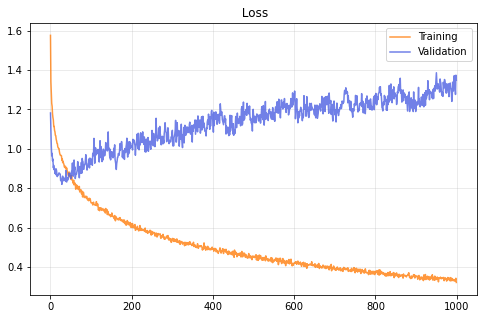

In [42]:
# Plot the accuracy
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(' Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

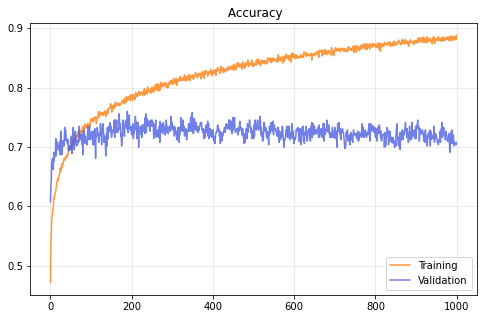

In [43]:
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(' Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

# Model saving
The model is saved and it can be reloaded if necessary.

In [ ]:
# Save the model
model.save(mode)